# Analyze Maricopa County, Arizona  Biodiversity Intactness Index (BII) changes from 2017-2020

Author: Hazel Vaquero

Repository Link: https://github.com/hazelvaq/Maricopa-Arizona-Changes-in-Biodiversity-Intactness-Index-.git 

## About 

In this notebook we analyse the changes observed in Biodiversity Intactness Index (BII) in Maricopa County, Phoenix, Arizona from 2017 to 2020. In 2021, Maricopa County was reported as the fastest growing county in the United States since 2001. It is the 4th largest county in terms of population. Urban development creates pressure on biodiversity and natural areas. This notebook seeks to analyze the impact of the rapid urban expansion in Maricopa County. 

## About the Datasets

In this notebook we use two different datasets:

**1. BII Data** 

The first dataset is from the [Planetary Computer Impact Observatory](https://planetarycomputer.microsoft.com/dataset/io-biodiversity). This dataset estimates terrestrial Biodiversity Intactness as a 100-meter gridded maps for the years 2017-2020. Biodiversity intactness is an estimated combination of two metrics:
- Abundance
- Compositional Similarity: how similar the composition of species is to an intact baseline

The collection we will be working with is `io-biodiversity`. 

**2. Phoenix Subdivison** 

The second dataste is from the [United Census Bureau](https://www.census.gov/cgi-bin/geo/shapefiles/). This data has been downloaded as a shapefile and has 19 columns. It contains the county names, land area and water area to name a few.    

## Final Output

The final visualization

### Import Libraries 

In [1]:
# Import Libraries
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import matplotlib.pyplot as plt

from shapely.geometry import Polygon

# Used to access STAC catalogs
from pystac_client import Client
# Used to sign items from the MPC STAC catalog
import planetary_computer

# other libraries for nice outputs
from IPython.display import Image

# Package to work with web-tiles for background maps
import contextily as ctx

### Catalog Search

We can narrow the search within the `catalog` by specifying our
- Time range: 2017 - 2020
- Area of Interest: `[-112.826843, 32.974108, -111.184387, 33.863574]`
- Collection name: `io-biodiversity`

In [2]:
# Data Import: BII data

## Acess Planatery Computer Catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

## Catalog Search
# Set temporal range
time_range = "2017/2020"
# Bonding box of Phoenix subdivision
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]
# catalog search
search = catalog.search(
    collections=['io-biodiversity'],
    bbox=bbox,
    datetime = time_range
)

Lets view the items in the catalog search and select the first item!

In [3]:
# Get items found in catalog search
items = search.item_collection()

# There are 4 items in our time range and area of interest
items

id: bii_2020_34.74464974521749_-115.38597824385106_cog
"bbox: [-115.3859782, 27.565314, -108.2066425, 34.7446497]"
datetime: None
proj:epsg: 4326
"proj:shape: [7992, 7992]"
end_datetime: 2020-12-31T23:59:59Z
"proj:transform: [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0]"
start_datetime: 2020-01-01T00:00:00Z
https://stac-extensions.github.io/projection/v1.0.0/schema.json
https://stac-extensions.github.io/raster/v1.1.0/schema.json
https://stac-extensions.github.io/version/v1.1.0/schema.json


We are interested in finding the BII diversity from 2017 to 2020. So we need to select both datasets. In our previous inspection of `items` we determined 2020 to be the first value of `items`. Our 2017 is our 4th value. 

In [19]:
# Select our 2017 item
item_2017 = items[3]

# Select our 2020 item
item_2020 = items[0]

Now we can view the item assets keys. Our assets of interest are:

- `data`: which contains the data we are interested in
- `rendered_preview`: a preview of our raster imagery

In [5]:
# Let's view our keys in assets
for key in item_2020.assets.keys():
    print(key, '--', item_2020.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


Let's view our rendered preview.

In [6]:
# plot 2017 rendered preview
Image(url=item_2017.assets['rendered_preview'].href, width=500)

In [7]:
# plot 2020 rendered preview
Image(url=item_2020.assets['rendered_preview'].href, width=500)

### Import Data

Now we can select our `data` from the catelog for our analysis  

#### Data Import: Maricopa County BII data

In [8]:
# 2017 Maricopa County data
bi_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)
bi_2017

# 2020 Maricopa County data
bi_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)
bi_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

#### Data Import: Arizona Counties shapefile 

In [9]:
# Data Import: Arizona counties shapefile
arizona_counties = gpd.read_file('data/tl_2022_04_cousub/tl_2022_04_cousub.shp')

# Data Import: U.S. states shapefile
us_states = gpd.read_file('data/states_shapefile/States_shapefile.shp')

## Prepare Data

In [10]:
# Lets make this lower case 
arizona_counties.columns = arizona_counties.columns.str.lower()

# Filter to Maricopa County
maricopa_county = arizona_counties[arizona_counties.name =='Maricopa-Stanfield']

# Let's view our results 
maricopa_county

,statefp,countyfp,cousubfp,cousubns,geoid,name,namelsad,lsad,classfp,mtfcc,cnectafp,nectafp,nctadvfp,funcstat,aland,awater,intptlat,intptlon,geometry
57,04,021,92091,01934958,0402192091,Maricopa-Stanfield,Maricopa-Stanfield CCD,22,Z5,G4040,NaN,NaN,NaN,S,1026963163,668887,+32.9120190,-112.0749104,"POLYGON ((-112.20357 32.68926, -112.20357 32.6..."


### Data Visualization

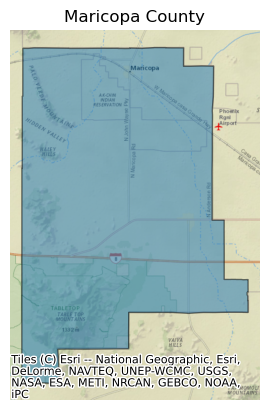

In [11]:
# Map of Maricopa with appropraite geographical context

fig, ax = plt.subplots()

(maricopa_county.to_crs(epsg=3857).plot(ax=ax, figsize = (20,20), alpha = 0.5, edgecolor = "k"))

ctx.add_basemap(ax=ax, source = ctx.providers.Esri.NatGeoWorldMap)

ax.set_title("Maricopa County")
ax.set_axis_off()

## Percentage of Area

#### Check CRS

In [12]:
# Let's make an if statement if its false to change the crs

# reproject maricopa_county to stack crs
maricopa_county = maricopa_county.to_crs(bi_2017.rio.crs)

print("CRS match:",maricopa_county.crs == bi_2017.rio.crs)

CRS match: True


In [13]:
# Lets crop the county data to the both rasters

# Clip 2017 BI raster
bi_2017 = bi_2017.rio.clip_box(*maricopa_county.total_bounds)

# Clip 2020 BI raster
bi_2020 = bi_2020.rio.clip_box(*maricopa_county.total_bounds)

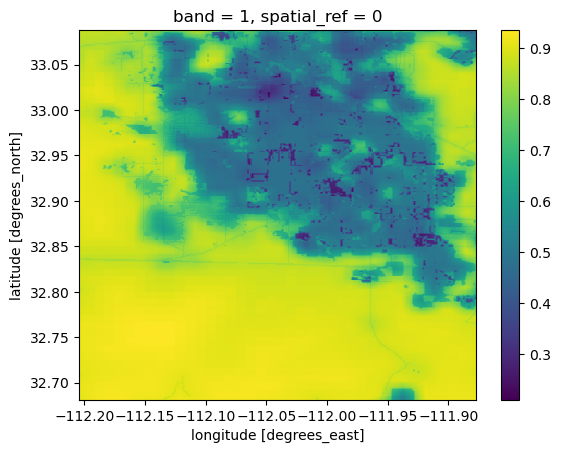

In [14]:
bi_2017.plot()

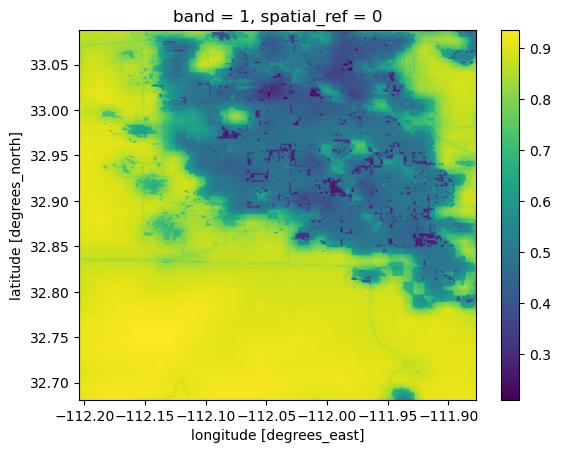

In [15]:
bi_2020.plot()